# Importing Libraries:

In [187]:
import bs4
import math
from bs4 import BeautifulSoup
import requests
import timeit
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import spacy
import warnings
warnings.filterwarnings("ignore")
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
import lightgbm as ltb
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import category_encoders as ce
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from gensim.models import KeyedVectors
from gensim import models
from sklearn import preprocessing

# Data Scrapping

In [188]:
def amazon_data(webpage, page_number, pages_to_extract):
    
    """
    Given a URL,page number and number of pages to extract; this function extracts review, date, summary
    and creates a dataframe
    
    """
    
    webpage = webpage[:-1]
    amazon_review = []
    amazon_date = []
    amazon_summary = []

    def scrape_data_amazon(webpage, page_number, pages_to_extract):
        next_page = webpage + str(page_number)
        response= requests.get(str(next_page))
        soup = BeautifulSoup(response.content,"html.parser")
        soup_review = soup.findAll("div",{"class":"a-row a-spacing-small review-data"})
        soup_summary = soup.findAll("a",{"class":"a-size-base a-link-normal review-title a-color-base review-title-content a-text-bold"})
        soup_date = soup.findAll("span",{"class":"a-size-base a-color-secondary review-date"})[2:] # 10 reviews
        for x in range(len(soup_review)):
            amazon_review.append(soup_review[x].text.strip())
            amazon_date.append(soup_date[x].text.strip())
            amazon_summary.append(soup_summary[x].text.strip())

   #Generating the next page url
        if page_number < pages_to_extract:
            page_number = page_number + 1
            #print(page_number)
            scrape_data_amazon(webpage, page_number,pages_to_extract)
            
    scrape_data_amazon(webpage, page_number, pages_to_extract)
    data_amazon = {'Date':amazon_date, 'Review': amazon_review, 'Summary':amazon_summary}
    df_amazon = pd.DataFrame(data_amazon, columns = ['Date','Review','Summary'])
    
    def get_date_amazon(text):
        return ' '.join(text.split()[-3:])
    
    df_amazon["Date"] = [get_date_amazon(x) for x in df_amazon["Date"].values]
    df_amazon.dropna(inplace = True)
    
    return df_amazon



In [189]:
url = 'https://www.amazon.in/New-Apple-iPhone-11-64GB/product-reviews/B08L8DV7BX/ref=cm_cr_getr_d_paging_btm_prev_1?ie=UTF8&reviewerType=all_reviews&pageNumber=1'
page = 1
extract = 300

starttime = timeit.default_timer()
df = amazon_data(url,page,extract)
print("Execution time :", timeit.default_timer() - starttime)

Execution time : 160.23851951000006


In [190]:
raw_data = df
raw_data

,Date,Review,Summary
0,12 August 2022,Superb,Name is enough
1,14 August 2022,superb,love it
2,13 August 2022,Ok,Ok
3,9 August 2022,Very nice,Good
4,13 August 2022,Nice,Nothing
...,...,...,...
2375,24 November 2020,All are good but charger and earpod are missing,Excellent
2376,11 July 2021,Excellent,Excellent
2377,23 December 2020,Happy with my busying decision. No issues with...,Purchased it on discount and very satisfied wi...
2378,16 December 2020,Extremely happy with IPhone 11. Bought it at 5...,Upgraded from IPhone 6 to IPhone 11


# Splitting Data:

In [191]:
x = raw_data.drop(["Summary"],axis = 1) # dropping the summary column

In [192]:
x_train,x_test = train_test_split(x,test_size = 0.2,random_state = 0) # splitting the data

In [193]:
x_train.shape,x_test.shape # size of train and test set

((1904, 2), (476, 2))

# Sentence Tokenization:

In [194]:
def split_review(text):
    """
    This function splits the review into multiple sentences based on the following conjunctions
    
    """
    delimiters = ".", "but", "and", "also"
    regex_pattern = '|'.join(map(re.escape, delimiters)) # applying the above delimiters
    splitted = re.split(regex_pattern, text) # splitting the review 
    return splitted # this returns a list of multiple reviews

# Data Cleaning:

In [195]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [196]:
lemma = WordNetLemmatizer() # applying lemmatization to return dictionary form of words

all_stopwords = stopwords.words('english') # this consists all the stopwords, which will be removed later.

# Removing the following words from list containing stopwords
all_stopwords.remove('not')
all_stopwords.remove('but')
all_stopwords.remove('because')
all_stopwords.remove('against')
all_stopwords.remove('between')
all_stopwords.remove('up')
all_stopwords.remove('down')
all_stopwords.remove('in')
all_stopwords.remove('out')
all_stopwords.remove('once')
all_stopwords.remove('before')
all_stopwords.remove('after')
all_stopwords.remove('few')
all_stopwords.remove('more')
all_stopwords.remove('most')
all_stopwords.remove('no')
all_stopwords.remove('nor')
all_stopwords.remove('same')
all_stopwords.remove('some')

def clean_aspect_spacy(reviews):
    """
    This function removes punctuations, stopwords and other non alpha numeric characters.
    We expand the contractions and replace some words by an empty string
    
    """
    statement = reviews.lower().strip()
    statement = statement.replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("*****"," ")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will").replace("doesn't", "does not")
    
    statement = re.sub('[^a-zA-Z]',' ',statement) # replacing whatever isn't letters by an empty string
    statement = statement.split() # forming list of words in a given review
    final_statement = [lemma.lemmatize(word) for word in statement if not word in set(all_stopwords)]
    final_statement_ = ' '.join(final_statement) # joining the words and forming the review again without stopwords
    return final_statement_  

# Form Dataframe again

In [197]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [198]:
def get_splitted_reviews(df):
    """
    This function applies the above defined splitting function and forms a dataframe again
    
    """
    reviews= [] # this will contain our reviews
    dates = [] # this will contain our dates

    for i,j in enumerate(df["Review"].values): # for each review
        review_split = split_review(j) # apply the splitting the function
        review_split_ = [x for x in review_split if len(x.split()) >= 3] # review containing less than 3 words are removed
        duplicate_dates = [str(df["Date"].values[i]) for h in range(len(review_split_))] # repeat the dates for splitted reviews
        reviews.extend(review_split_) # add reviews to list
        dates.extend(duplicate_dates) # add dates to list
        
    reviews_ = [clean_aspect_spacy(text) for text in reviews] # applying the cleaning function 
        
    data = pd.DataFrame({"Date": dates,"Review": reviews_}) # create new dataframe
    return data

In [199]:
# Train set:

starttime = timeit.default_timer()
train_data = get_splitted_reviews(x_train) 
print("The time difference is :", timeit.default_timer() - starttime)

The time difference is : 0.6005813249998937


In [200]:
# Test set:

starttime = timeit.default_timer()
test_data = get_splitted_reviews(x_test)
print("The time difference is :", timeit.default_timer() - starttime)

The time difference is : 0.13655680600004416


In [201]:
train_data

,Date,Review
0,30 August 2021,good performance
1,20 November 2020,apple apple product nice
2,20 November 2020,easy use
3,20 November 2020,bundal watt charger u buy new fast charger enj...
4,20 November 2020,face id wonderful
...,...,...
7196,17 October 2020,sound quality one power rich in heaven
7197,17 October 2020,actually express inner feeling smooth well good
7198,14 November 2021,great product came expected
7199,14 November 2021,yes not fake believe rumour


In [202]:
test_data

,Date,Review
0,1 September 2022,costly thing provided
1,1 September 2022,also provide charging adapter phone
2,1 September 2022,time go slow feel slow esp after release new p...
3,10 January 2021,product good
4,10 January 2021,battery get zero within hour after six month c...
...,...,...
1630,6 August 2021,wonderful iphone specially dy not want yo carr...
1631,6 August 2021,due hard fan iphone
1632,17 November 2021,nice mobile genuine seller
1633,10 October 2021,experienced heating issue in iphone otherwise ...


# Aspect Extraction:

In [203]:
def apply_extraction(row,nlp):
    """
    This function extracts aspect and its corresponding description from the review by 
    applying 7 different rules of pos tagging
    
    """
    
    prod_pronouns = ['it','this','they','these']
    review_body = row['Review']
    doc=nlp(review_body)
    
    rule1_pairs = []
    rule2_pairs = []
    rule3_pairs = []
    rule4_pairs = []
    rule5_pairs = []
    rule6_pairs = []
    rule7_pairs = []
    
    for token in doc:
        A = "999999"
        M = "999999"
        if token.dep_ == "amod" and not token.is_stop:
            M = token.text
            A = token.head.text

            # add adverbial modifier of adjective (e.g. 'most comfortable headphones')
            M_children = token.children
            for child_m in M_children:
                if(child_m.dep_ == "advmod"):
                    M_hash = child_m.text
                    M = M_hash + " " + M
                    break

            # negation in adjective, the "no" keyword is a 'det' of the noun (e.g. no interesting characters)
            A_children = token.head.children
            for child_a in A_children:
                if(child_a.dep_ == "det" and child_a.text == 'no'):
                    neg_prefix = 'not'
                    M = neg_prefix + " " + M
                    break

        if(A != "999999" and M != "999999"):
            if A in prod_pronouns :
                A = "product"
            dict1 = {"noun" : A, "adj" : M, "rule" : 1}
            rule1_pairs.append(dict1)

        #print("--- SPACY : Rule 1 Done ---")
        
# -----------------------------------------------------------------------------------------------------------------------------        
        # # SECOND RULE OF DEPENDANCY PARSE -
        # # M - Sentiment modifier || A - Aspect
        # Direct Object - A is a child of something with relationship of nsubj, while
        # M is a child of the same something with relationship of dobj
        # Assumption - A verb will have only one NSUBJ and DOBJ
        children = token.children
        A = "999999"
        M = "999999"
        add_neg_pfx = False
        for child in children :
            if(child.dep_ == "nsubj" and not child.is_stop):
                A = child.text
                # check_spelling(child.text)

            if((child.dep_ == "dobj" and child.pos_ == "ADJ") and not child.is_stop):
                M = child.text
                #check_spelling(child.text)

            if(child.dep_ == "neg"):
                neg_prefix = child.text
                add_neg_pfx = True

        if (add_neg_pfx and M != "999999"):
            M = neg_prefix + " " + M

        if(A != "999999" and M != "999999"):
            if A in prod_pronouns :
                A = "product"
            dict2 = {"noun" : A, "adj" : M, "rule" : 2}
            rule2_pairs.append(dict2)

        #print("--- SPACY : Rule 2 Done ---")
# -----------------------------------------------------------------------------------------------------------------------------

        ## THIRD RULE OF DEPENDANCY PARSE -
        ## M - Sentiment modifier || A - Aspect
        ## Adjectival Complement - A is a child of something with relationship of nsubj, while
        ## M is a child of the same something with relationship of acomp
        ## Assumption - A verb will have only one NSUBJ and DOBJ
        ## "The sound of the speakers would be better. The sound of the speakers could be better" - handled using AUX dependency

        children = token.children
        A = "999999"
        M = "999999"
        add_neg_pfx = False
        for child in children :
            if(child.dep_ == "nsubj" and not child.is_stop):
                A = child.text
                # check_spelling(child.text)

            if(child.dep_ == "acomp" and not child.is_stop):
                M = child.text

            # example - 'this could have been better' -> (this, not better)
            if(child.dep_ == "aux" and child.tag_ == "MD"):
                neg_prefix = "not"
                add_neg_pfx = True

            if(child.dep_ == "neg"):
                neg_prefix = child.text
                add_neg_pfx = True

        if (add_neg_pfx and M != "999999"):
            M = neg_prefix + " " + M
                #check_spelling(child.text)

        if(A != "999999" and M != "999999"):
            if A in prod_pronouns :
                A = "product"
            dict3 = {"noun" : A, "adj" : M, "rule" : 3}
            rule3_pairs.append(dict3)
            #rule3_pairs.append((A, M, sid.polarity_scores(M)['compound'],3))
#print("--- SPACY : Rule 3 Done ---")
# ------------------------------------------------------------------------------------------------------------------------------
 
        ## FOURTH RULE OF DEPENDANCY PARSE -
        ## M - Sentiment modifier || A - Aspect

        #Adverbial modifier to a passive verb - A is a child of something with relationship of nsubjpass, while
        # M is a child of the same something with relationship of advmod

        #Assumption - A verb will have only one NSUBJ and DOBJ

        children = token.children
        A = "999999"
        M = "999999"
        add_neg_pfx = False
        for child in children :
            if((child.dep_ == "nsubjpass" or child.dep_ == "nsubj") and not child.is_stop):
                A = child.text
                # check_spelling(child.text)

            if(child.dep_ == "advmod" and not child.is_stop):
                M = child.text
                M_children = child.children
                for child_m in M_children:
                    if(child_m.dep_ == "advmod"):
                        M_hash = child_m.text
                        M = M_hash + " " + child.text
                        break
                #check_spelling(child.text)

            if(child.dep_ == "neg"):
                neg_prefix = child.text
                add_neg_pfx = True

        if (add_neg_pfx and M != "999999"):
            M = neg_prefix + " " + M

        if(A != "999999" and M != "999999"):
            if A in prod_pronouns :
                A = "product"
            dict4 = {"noun" : A, "adj" : M, "rule" : 4}
            rule4_pairs.append(dict4)
            #rule4_pairs.append((A, M,sid.polarity_scores(M)['compound'],4)) # )

#print("--- SPACY : Rule 4 Done ---")
# ------------------------------------------------------------------------------------------------------------------------------

        ## FIFTH RULE OF DEPENDANCY PARSE -
        ## M - Sentiment modifier || A - Aspect

        #Complement of a copular verb - A is a child of M with relationship of nsubj, while
        # M has a child with relationship of cop

        #Assumption - A verb will have only one NSUBJ and DOBJ

        children = token.children
        A = "999999"
        buf_var = "999999"
        for child in children :
            if(child.dep_ == "nsubj" and not child.is_stop):
                A = child.text
                # check_spelling(child.text)

            if(child.dep_ == "cop" and not child.is_stop):
                buf_var = child.text
                #check_spelling(child.text)

        if(A != "999999" and buf_var != "999999"):
            if A in prod_pronouns :
                A = "product"
            dict5 = {"noun" : A, "adj" : token.text, "rule" : 5}
            rule5_pairs.append(dict5)
            #rule5_pairs.append((A, token.text,sid.polarity_scores(token.text)['compound'],5))

#print("--- SPACY : Rule 5 Done ---")
# ------------------------------------------------------------------------------------------------------------------------------

        ## SIXTH RULE OF DEPENDANCY PARSE -
        ## M - Sentiment modifier || A - Aspect
        ## Example - "It ok", "ok" is INTJ (interjections like bravo, great etc)

        children = token.children
        A = "999999"
        M = "999999"
        if(token.pos_ == "INTJ" and not token.is_stop):
            for child in children :
                if(child.dep_ == "nsubj" and not child.is_stop):
                    A = child.text
                    M = token.text
                    # check_spelling(child.text)

        if(A != "999999" and M != "999999"):
            if A in prod_pronouns :
                A = "product"
            dict6 = {"noun" : A, "adj" : M, "rule" : 6}
            rule6_pairs.append(dict6)

            #rule6_pairs.append((A, M,sid.polarity_scores(M)['compound'],6))

#print("--- SPACY : Rule 6 Done ---")
    
# ------------------------------------------------------------------------------------------------------------------------------

        ## SEVENTH RULE OF DEPENDANCY PARSE -
    ## M - Sentiment modifier || A - Aspect
    ## ATTR - link between a verb like 'be/seem/appear' and its complement
    ## Example: 'this is garbage' -> (this, garbage)

        children = token.children
        A = "999999"
        M = "999999"
        add_neg_pfx = False
        for child in children :
            if(child.dep_ == "nsubj" and not child.is_stop):
                A = child.text
                # check_spelling(child.text)

            if((child.dep_ == "attr") and not child.is_stop):
                M = child.text
                #check_spelling(child.text)

            if(child.dep_ == "neg"):
                neg_prefix = child.text
                add_neg_pfx = True

        if (add_neg_pfx and M != "999999"):
            M = neg_prefix + " " + M

        if(A != "999999" and M != "999999"):
            if A in prod_pronouns :
                A = "product"
            dict7 = {"noun" : A, "adj" : M, "rule" : 7}
            rule7_pairs.append(dict7)
            #rule7_pairs.append((A, M,sid.polarity_scores(M)['compound'],7))



#print("--- SPACY : All Rules Done ---")
    
# ------------------------------------------------------------------------------------------------------------------------------

    aspects = []

    aspects = rule1_pairs + rule2_pairs + rule3_pairs +rule4_pairs +rule5_pairs + rule6_pairs + rule7_pairs

    dic = {"aspect_pairs" : aspects}
    return dic

In [204]:
def extract_aspects(reviews,nlp):
    
    """
    Applying the aspect extraction function and returning a dictionary 
    with key = Aspect & value = Description
    
    """
    print("Entering Apply function!")
    aspect_list = reviews.apply(lambda row: apply_extraction(row,nlp), axis=1) #going through all the rows in the dataframe
    return aspect_list

In [205]:
nlp = spacy.load("en_core_web_sm") # loading the library

In [206]:
reviews_train = train_data[["Review"]] # extracting aspects from train set

In [207]:
reviews_test = test_data[["Review"]] # extracting aspects from test set

In [208]:
# Train set
starttime = timeit.default_timer()

aspect_list_train = extract_aspects(reviews_train,nlp)
aspect_list_train = list(aspect_list_train)

print("Execution Time :", timeit.default_timer() - starttime)

Entering Apply function!
Execution Time : 50.36931649799999


In [209]:
# Test set
starttime = timeit.default_timer()

aspect_list_test = extract_aspects(reviews_test,nlp)
aspect_list_test = list(aspect_list_test)

print("Execution Time :", timeit.default_timer() - starttime)

Entering Apply function!
Execution Time : 11.463111323999783


In [210]:
def add_data(data,aspect_list):    
    """
    This function adds aspect and the description to the dataframe such that if one review has multiple aspects,
    then the reviews are repeated such that each row consists of single aspect and description
    
    """
    rev_ = [] # list containing reviews
    dates_ = [] # list containing dates
    aspects_ = [] # list containing aspects
    description_ = [] # list containing description
    
    
    for i,j in enumerate(aspect_list):
        length = len(list(j.values())[0])
        if len(list(j.values())[0]) != 0:
            rev_a = [data["Review"].values[i] for k in range(len(list(j.values())[0]))]
            dates_a = [data["Date"].values[i] for k in range(len(list(j.values())[0]))] 
            aspects_a = [list(j.values())[0][h]["noun"] for h in range(length)]
            descrip_a = [list(j.values())[0][h]["adj"] for h in range(length)]
        
            rev_.extend(rev_a)
            dates_.extend(dates_a)
            aspects_.extend(aspects_a)
            description_.extend(descrip_a)
        
        # if a review doesn't contain any aspect then we add "neutral" for both the aspect & description column
    
        else: 
            rev_.append(data["Review"].values[i])
            dates_.append(data["Date"].values[i])
            aspects_.append('neutral')
            description_.append('neutral')
        
    data_ = pd.DataFrame({"Date": dates_,"Review": rev_,"Aspect":aspects_,"Description":description_})
    return data_

In [211]:
# Train set

train_data_with_aspects = add_data(train_data,aspect_list_train)

In [212]:
# Test set

test_data_with_aspects = add_data(test_data,aspect_list_test)

In [213]:
train_data_with_aspects

,Date,Review,Aspect,Description
0,30 August 2021,good performance,performance,good
1,20 November 2020,apple apple product nice,product,nice
2,20 November 2020,easy use,use,easy
3,20 November 2020,bundal watt charger u buy new fast charger enj...,charger,new
4,20 November 2020,bundal watt charger u buy new fast charger enj...,charger,fast
...,...,...,...,...
9175,14 November 2021,yes not fake believe rumour,rumour,fake
9176,17 July 2021,nice product delivery getting late appario ret...,delivery,nice
9177,17 July 2021,nice product delivery getting late appario ret...,seller,late
9178,17 July 2021,nice product delivery getting late appario ret...,seller,retile


In [214]:
test_data_with_aspects

,Date,Review,Aspect,Description
0,1 September 2022,costly thing provided,thing,costly
1,1 September 2022,also provide charging adapter phone,neutral,neutral
2,1 September 2022,time go slow feel slow esp after release new p...,phone,new
3,10 January 2021,product good,product,good
4,10 January 2021,battery get zero within hour after six month c...,battery,changed
...,...,...,...,...
2032,17 November 2021,nice mobile genuine seller,seller,nice
2033,17 November 2021,nice mobile genuine seller,genuine,mobile
2034,17 November 2021,nice mobile genuine seller,seller,genuine
2035,10 October 2021,experienced heating issue in iphone otherwise ...,issue,experienced


# Sentiment / polarity:

In [215]:
# Vader sentiment analysis:
def sentiment_scores(sentence):
    senti = SentimentIntensityAnalyzer() 
    sentiment_dict = senti.polarity_scores(sentence) # this line returns the polarity for sentence
  
    if sentiment_dict['compound'] >= 0.05 : # if the compound score is >= 0.05 then the review is positive
        return ("Positive"),sentiment_dict['pos'],sentiment_dict['compound']

    elif sentiment_dict['compound'] <= - 0.05 : # if the compound score is <= -0.05 then the review is negative
        return ("Negative"),sentiment_dict['neg'],sentiment_dict['compound']

    else :
        return ("Neutral"),sentiment_dict['neu'],sentiment_dict['compound'] # if compound score is in between 0.05 and -0.05 then the review is neutral
    
# Reference---> (https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/)

In [216]:
def form_final_data(data):
    starttime = timeit.default_timer()
    
    sentiment_ = [] # this list carries the sentiment for the review
    #pol_value = [] # this list consists of  the polarity for the review
    compound = [] # this consists of score based on which the sentiments are defined

    for u in data["Review"].values: # applying the above defined function by iterating through each review
        a,b,c = sentiment_scores(u)
        sentiment_.append(a)
        #pol_value.append(b)
        compound.append(c)
        
    data["Sentiment"] = sentiment_ # adding the sentiment to dataframe
    #data["Polarity"] = pol_value
    data["Score"] = compound # adding the score to dataframe
    
    data["Date"] = pd.to_datetime(data['Date']) 
    data.sort_values(by = 'Date', inplace = True) # sorting the date in ascending order
    
    data["Year"] = pd.DatetimeIndex(data['Date']).year # extracting year from date
    data["Month"] = pd.DatetimeIndex(data['Date']).month # extracting month from date
    data["Week"] = pd.DatetimeIndex(data['Date']).week # extracting week from date
    
    final_dff = data.reset_index().drop(["index"], axis=1) # resetting the index
    
    print("The time difference is :", timeit.default_timer() - starttime)
    return final_dff

In [217]:
final_train = form_final_data(train_data_with_aspects)

The time difference is : 116.32936665200032


In [218]:
final_test = form_final_data(test_data_with_aspects)

The time difference is : 25.65609221800014


In [219]:
final_train

,Date,Review,Aspect,Description,Sentiment,Score,Year,Month,Week
0,2019-09-30,must try slow motion selfie,selfie,slow,Neutral,0.0000,2019,9,40
1,2019-09-30,must say really impressed,neutral,neutral,Positive,0.5256,2019,9,40
2,2019-09-30,speechless not ask more,neutral,neutral,Neutral,0.0000,2019,9,40
3,2019-09-30,planning buy premium phone,phone,premium,Neutral,0.0000,2019,9,40
4,2019-09-30,,neutral,neutral,Neutral,0.0000,2019,9,40
...,...,...,...,...,...,...,...,...,...
9175,2022-08-17,medium could not loaded,neutral,neutral,Neutral,0.0000,2022,8,33
9176,2022-08-17,month since purchased,neutral,neutral,Neutral,0.0000,2022,8,33
9177,2022-08-27,bad battery,battery,bad,Negative,-0.5423,2022,8,34
9178,2022-09-13,not recommend go definitely go eleven worst ba...,battery,worst,Negative,-0.9112,2022,9,37


In [220]:
final_test

,Date,Review,Aspect,Description,Sentiment,Score,Year,Month,Week
0,2019-09-28,got guy,neutral,neutral,Neutral,0.0000,2019,9,39
1,2019-09-28,matter,neutral,neutral,Neutral,0.0258,2019,9,39
2,2019-09-28,display could oled in price,neutral,neutral,Neutral,0.0000,2019,9,39
3,2019-09-28,best processor bionic chipcons,chipcons,bionic,Positive,0.6369,2019,9,39
4,2019-09-28,best processor bionic chipcons,chipcons,best,Positive,0.6369,2019,9,39
...,...,...,...,...,...,...,...,...,...
2032,2022-07-25,review amazon customer service,neutral,neutral,Positive,0.1779,2022,7,30
2033,2022-07-31,month use battery life percent not good prodecut,prodecut,good,Negative,-0.3412,2022,7,30
2034,2022-09-01,time go slow feel slow esp after release new p...,phone,new,Neutral,0.0000,2022,9,35
2035,2022-09-01,also provide charging adapter phone,neutral,neutral,Neutral,0.0000,2022,9,35


# Basic Feature Extraction:

In [221]:
def character_count(text):
    """
    This function returns the number of letters in a review
    
    """
    return len(text)

def word_count(text):
    """
    This function returns the number of words in a review
    
    """
    return len(text.split())

def unique_words(text):
    """
    This function returns the number of unique words in a review
    
    """
    return len(set(text.split()))

In [222]:
# Train set:

final_train['char_count'] = final_train["Review"].apply(lambda x:character_count(x))
final_train['word_count'] = final_train["Review"].apply(lambda x:word_count(x))
final_train['unique_word_count'] = final_train["Review"].apply(lambda x:unique_words(x))
final_train['avg_wordlength'] = final_train['char_count']/final_train['word_count']
final_train['unique_vs_words'] = final_train['unique_word_count']/final_train['word_count']

In [223]:
# Test set:

final_test['char_count'] = final_test["Review"].apply(lambda x:character_count(x))
final_test['word_count'] = final_test["Review"].apply(lambda x:word_count(x))
final_test['unique_word_count'] = final_test["Review"].apply(lambda x:unique_words(x))
final_test['avg_wordlength'] = final_test['char_count']/final_test['word_count']
final_test['unique_vs_words'] = final_test['unique_word_count']/final_test['word_count']

# Data Visualization:

# Frequency of top 30 Aspects:

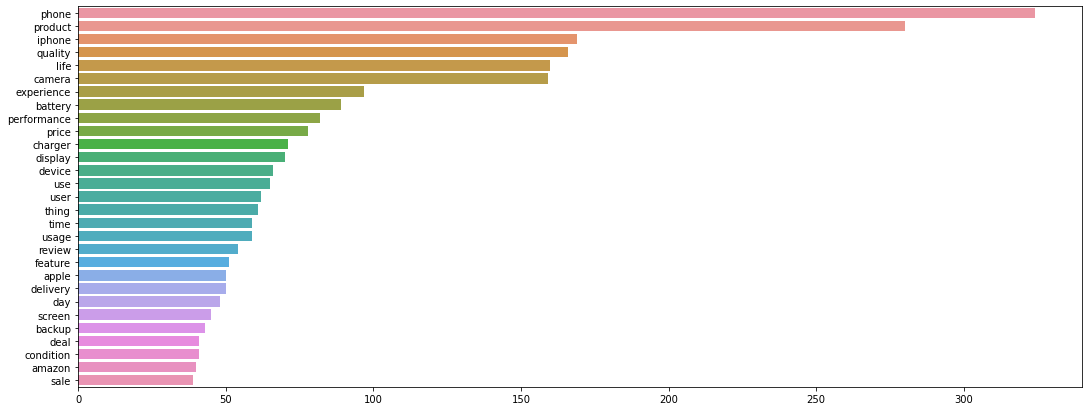

In [224]:
top = final_train["Aspect"].value_counts()[1:30]
asp = list(dict(top).keys())
count = list(dict(top).values())

plt.figure(figsize=(18, 7))
sns.barplot(x=count,y=asp)

# Overall Sentiment for Unigram & Bigram aspects:

In [225]:
def count_avg(data,group_name,text,text2):
    """
    This function returns the overall sentiment for an aspect by calculating the mean of the column (score)
    
    """
    dict_version = {}
    form_group = data.groupby(by = (group_name))
    for i in list(dict(data[group_name].value_counts()).keys())[1:30]:
        get_aspect = form_group.get_group(i)
        result = get_aspect["Score"].mean() # calculating the mean of score for a particular aspect
        dict_version[i] = result
    
    plt.figure(figsize=(18, 7))
    x_ver = list(dict_version.keys())
    y_ver = sorted(list(dict_version.values()))
    plt.barh(x_ver,y_ver)
    plt.xlabel(text2, fontsize = 16)
    plt.ylabel("Aspects", fontsize = 16)
    plt.title(text,fontsize = 16)
    return plt.show() 

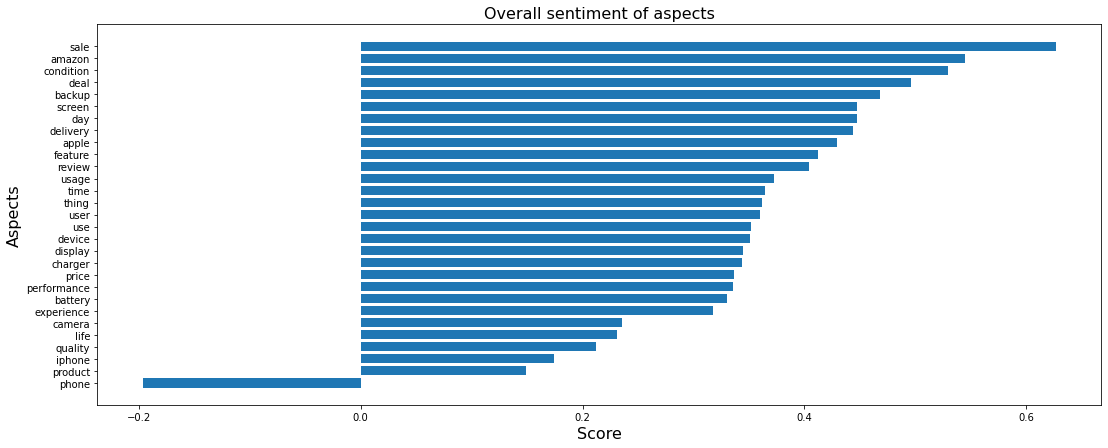

In [226]:
count_avg(final_train,'Aspect','Overall sentiment of aspects','Score')

# Overall Sentiments over a Time Period:

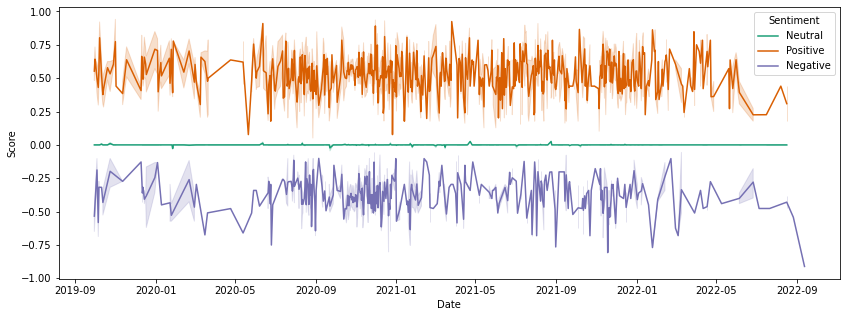

In [227]:
plt.figure(figsize=(14, 5))
sns.lineplot(x="Date", y="Score", data=final_train, hue="Sentiment", palette="Dark2")

fig = px.pie(final_train, values= list(dict(final_train["Sentiment"].value_counts()).values()),
             names=list(dict(final_train["Sentiment"].value_counts()).keys()), 
             title='Sentiments across reviews', width = 400, height = 400)
fig.show()

# Basic Feature Visualization:

In [228]:
final_train.head(2)

,Date,Review,Aspect,Description,Sentiment,Score,Year,Month,Week,char_count,word_count,unique_word_count,avg_wordlength,unique_vs_words
0,2019-09-30,must try slow motion selfie,selfie,slow,Neutral,0.0000,2019,9,40,27,5,5,5.40,1.0
1,2019-09-30,must say really impressed,neutral,neutral,Positive,0.5256,2019,9,40,25,4,4,6.25,1.0


In [229]:
def basic_feature_plots(target,feature,data):
    """
    This function helps to plot distributio of featuers and shows the target class
    
    """
    plt.figure(figsize=(12, 6))

    plt.subplot(1,2,1)
    sns.violinplot(x = target, y = feature, data = data)

    plt.subplot(1,2,2)
    sns.kdeplot(data[data[target] == "Positive"][feature] , label = "Positive", color = 'green')
    sns.kdeplot(data[data[target] == "Negative"][feature] , label = "Negative" , color = 'red')
    sns.kdeplot(data[data[target] == "Neutral"][feature] , label = "Neutral" , color = 'blue')
    plt.legend()


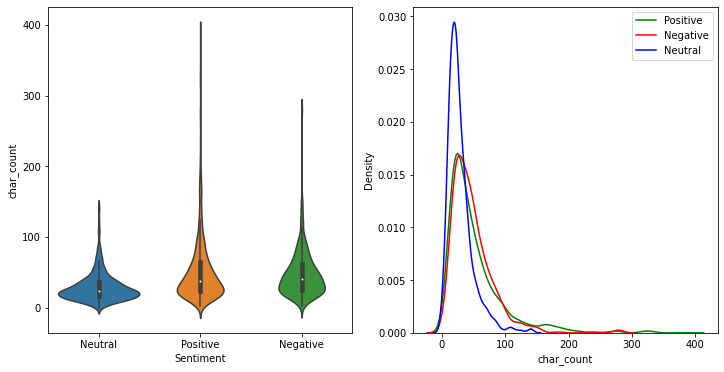

In [230]:
basic_feature_plots("Sentiment","char_count",final_train)

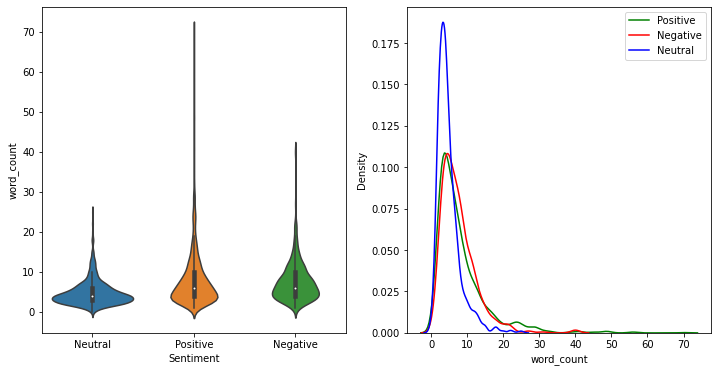

In [231]:
basic_feature_plots("Sentiment","word_count",final_train)

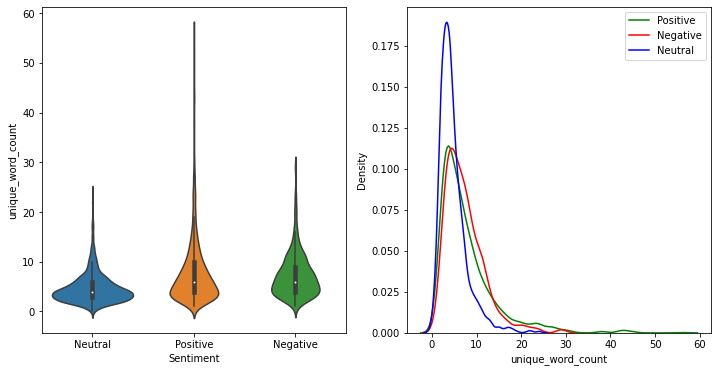

In [232]:
basic_feature_plots("Sentiment","unique_word_count",final_train)

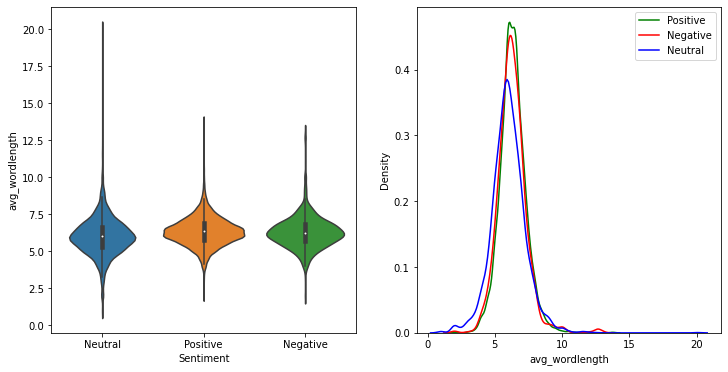

In [233]:
basic_feature_plots("Sentiment","avg_wordlength",final_train)  

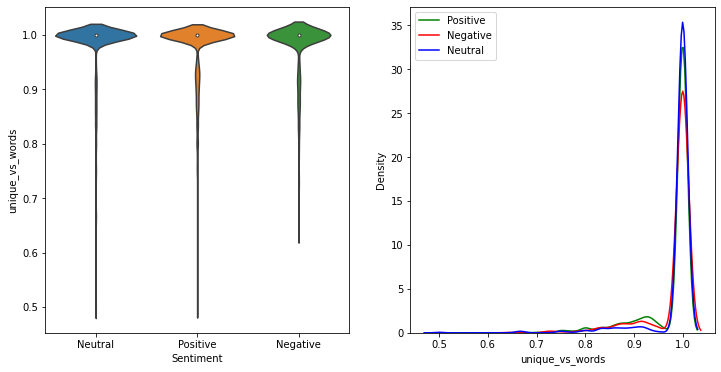

In [234]:
basic_feature_plots("Sentiment","unique_vs_words",final_train)

# Aspect based sentiments:

In [235]:
def aspect_plots(data,col_name,aspect_name):
    """
    For a given aspect, this function plots the pie chart and line plot 
    
    """
    s1 = data.groupby(by = col_name)
    s2 = s1.get_group(aspect_name)
    plt.figure(figsize=(14, 5))
    plt.title("Sentiment for {} acorss a time period".format(aspect_name))
    sns.lineplot(x="Date", y="Score", data=s2, hue="Sentiment", palette="Dark2")

    fig = px.pie(s2, values= list(dict(s2["Sentiment"].value_counts()).values()),
             names=list(dict(s2["Sentiment"].value_counts()).keys()), title = ("Sentiment for {}".format(aspect_name)),
            width = 400, height = 400)
    fig.show()

In [236]:
data = final_train
col_name = "Aspect"
aspect_name = "display"

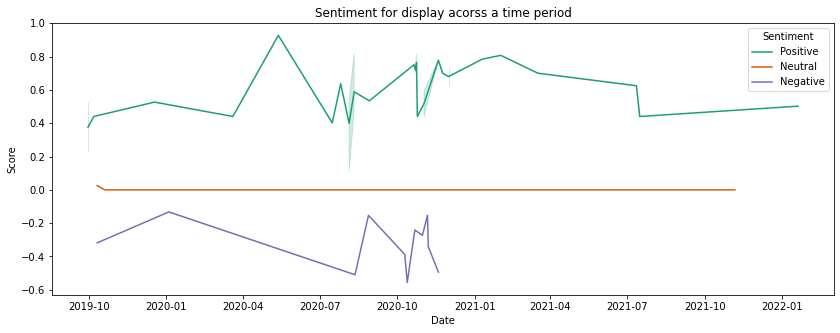

In [237]:
aspect_plots(data,col_name,aspect_name)

In [238]:
def display_reviews(data,aspect_name):
    """
    This function helps us to see the reviews which talk about a particular aspect
    
    """
    face = [x for x,value in enumerate(data['Review'].values) if aspect_name in value]

    get_reviews =[data['Review'].values[k] for k in face]
    get_sentiments = [data['Sentiment'].values[k] for k in face]

    data = pd.DataFrame({"Review" : get_reviews, "Sentiment" : get_sentiments})
    data_display = data.drop_duplicates(subset = ["Review"])
    data_display_ = data_display.reset_index().drop(["index"], axis=1)
    return data_display_

In [239]:
final_display = display_reviews(data,aspect_name)
final_display

,Review,Sentiment
0,really impressed display,Positive
1,pixel pepper display play important role,Positive
2,worth because not premium display,Positive
3,display more le good,Positive
4,trust display good phone same chipset pro vers...,Positive
...,...,...
168,display missing amoled,Negative
169,go iphone getting beautiful display experience,Positive
170,iphone display not bad beat k flagship,Positive
171,display quality worst,Negative


In [240]:
final_display["Sentiment"].value_counts()

Positive    110
Neutral      34
Negative     29
Name: Sentiment, dtype: int64

In [241]:
def wc(data,col_name,aspect_name):
    """
    For a given aspect this function plots the wordcloud for the description
    
    """
    s1 = data.groupby(by = col_name)
    s2 = s1.get_group(aspect_name)
    s3 = s2["Description"].values
    
    wordcloud = WordCloud(background_color = 'black', width = 512,height = 384,contour_color='black',contour_width=1,
                         colormap='RdYlGn',collocations=True).generate(' '.join(s3))
    plt.title("Descriptions of {}".format(aspect_name), fontsize = 20)
    plt.imshow(wordcloud) # image show
    plt.axis('off') # to off the axis of x and y
    plt.show()

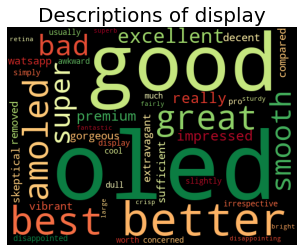

In [242]:
wc(data,col_name,aspect_name)

# Data Preprocessing:

- Month & Week----> **Cyclical Encoding**
- Review----> **TFIDF**
- Aspect & Description----> **Word2Vec**

In [243]:
# Select the features to be used for modeling:

X_train = final_train[["Review","Aspect","Description","Month","Week","char_count","word_count","unique_word_count",
                      "avg_wordlength","unique_vs_words"]]
X_test = final_test[["Review","Aspect","Description","Month","Week","char_count","word_count","unique_word_count",
                      "avg_wordlength","unique_vs_words"]]

In [244]:
# Select the target variable:

y_train = final_train["Score"]
y_test = final_test["Score"]

# Cyclical Encoding for Month & Week:

In [245]:
# Adding the encoded values to train set.
X_train['month_sin'] = np.sin((X_train.Month -1)*(2.*np.pi/12))
X_train['month_cos'] = np.cos((X_train.Month -1)*(2.*np.pi/12))
X_train['weekday_sin'] = np.sin((X_train.Week-1)*(2.*np.pi/53))
X_train['weekday_cos'] = np.cos((X_train.Week-1)*(2.*np.pi/53))

In [246]:
# Adding the encoded values to test set.
X_test['month_sin'] = np.sin((X_test.Month -1)*(2.*np.pi/12))
X_test['month_cos'] = np.cos((X_test.Month -1)*(2.*np.pi/12))
X_test['weekday_sin'] = np.sin((X_test.Week-1)*(2.*np.pi/53))
X_test['weekday_cos'] = np.cos((X_test.Week-1)*(2.*np.pi/53))

# TF-IDF

In [247]:
tfidf = TfidfVectorizer(min_df=10,ngram_range=(1,3), max_features=500)

tfidf_train = tfidf.fit_transform(X_train['Review'].values)
tfidf_test = tfidf.transform(X_test['Review'].values)

print('train data shape',tfidf_train.shape)
print('='*100)
print('test data shape',tfidf_test.shape)

train data shape (9180, 500)
test data shape (2037, 500)


In [248]:
tfidf_train = tfidf_train.toarray()
tfidf_test = tfidf_test.toarray()

#  W2V:

In [249]:
#import gensim.downloader as api

#w2v_model = api.load('word2vec-google-news-300')

In [250]:
#w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

w2v_model_ = w2v_model

In [251]:
def get_w2v(aspect):
    """
    Given an aspect, this function returns  Word2Vec for the word
    
    """
    
    sent_vector = np.zeros(300) # since W2v gives 300 dimension representation for each word
    try:
        vector = w2v_model_[aspect] # getting w2v vector for the word
        sent_vector += vector # adding this vector for performing Average W2v
    except KeyError:
        sent_vector += np.zeros(300)
    sent_vector_final = sent_vector
    return sent_vector_final

In [252]:
# Getting the W2V vector for train set

w2v_aspect_train = np.array([get_w2v(i) for i in X_train["Aspect"].values])
w2v_description_train = np.array([get_w2v(i) for i in X_train["Description"].values])

In [253]:
# Getting the W2V vector for test set

w2v_aspect_test = np.array([get_w2v(i) for i in X_test["Aspect"].values])
w2v_description_test = np.array([get_w2v(i) for i in X_test["Description"].values])

# Concatenation:

In [254]:
# Concatenating all the features 

training_data = np.hstack((tfidf_train,w2v_aspect_train,w2v_description_train,X_train["month_sin"].values.reshape(-1,1),
                X_train["month_cos"].values.reshape(-1,1),X_train["weekday_sin"].values.reshape(-1,1),
                X_train["weekday_cos"].values.reshape(-1,1),X_train['char_count'].values.reshape(-1,1),
                X_train['word_count'].values.reshape(-1,1),X_train['unique_word_count'].values.reshape(-1,1),
                X_train['avg_wordlength'].values.reshape(-1,1),X_train['unique_vs_words'].values.reshape(-1,1)))

training_data.shape

(9180, 1109)

In [255]:
testing_data = np.hstack((tfidf_test,w2v_aspect_test,w2v_description_test,X_test["month_sin"].values.reshape(-1,1),
                X_test["month_cos"].values.reshape(-1,1),X_test["weekday_sin"].values.reshape(-1,1),
                X_test["weekday_cos"].values.reshape(-1,1),X_test['char_count'].values.reshape(-1,1),
                X_test['word_count'].values.reshape(-1,1),X_test['unique_word_count'].values.reshape(-1,1),
                X_test['avg_wordlength'].values.reshape(-1,1),X_test['unique_vs_words'].values.reshape(-1,1)))

testing_data.shape

(2037, 1109)

# Modeling:

# LGB:

- The LGB Regressor model gives the best performance without using hyperparametre optimization

In [256]:
lgb = ltb.LGBMRegressor()
lgb.fit(training_data, y_train)

LGBMRegressor()

In [257]:
lgb_predict_train = lgb.predict(training_data)
lgb_predict_test = lgb.predict(testing_data)

In [258]:
r2_train = r2_score(y_train,lgb_predict_train)
r2_test = r2_score(y_test,lgb_predict_test)

print("R2 Score on train set :",r2_train)
print("R2 Score on test set :",r2_test)

R2 Score on train set : 0.8454592420686778
R2 Score on test set : 0.6462480419650449


In [259]:
mse_train = mean_squared_error(y_train,lgb_predict_train)
mse_test = mean_squared_error(y_test,lgb_predict_test)

print("RMSE train :",math.sqrt(mse_train))
print("RMSE test :",math.sqrt(mse_test))

RMSE train : 0.15208108051113706
RMSE test : 0.2360249775532124


# Interpretation of the results:

In [260]:
# stacking the actual and predicted results to form the dataframe

interpret = np.hstack((np.array(y_test).reshape(-1,1),lgb_predict_test.reshape(-1,1)))

In [261]:
interpret_df = pd.DataFrame(interpret)

In [262]:
interpret_df["Actual_sentiment"] = final_test["Sentiment"] # adding the actual sentiment

In [263]:
interpret_df.columns = ["Actual","Predicted","Actual_sentiment"] # renaming the columns

In [264]:
# Converting the precited scores to sentiments

senti = [] # this list carries the sentiment for the review
   
for u in interpret_df["Predicted"].values: 
    if u >= 0.05:
        senti.append("Positive")
    elif u <=-0.05:
        senti.append("Negative")
    else:
        senti.append("Neutral")

In [265]:
interpret_df["Predicted_sentiment"] = senti # adding the predicted sentiments to dataframe

In [266]:
interpret_df

,Actual,Predicted,Actual_sentiment,Predicted_sentiment
0,0.0000,0.027122,Neutral,Neutral
1,0.0258,0.027122,Neutral,Neutral
2,0.0000,0.038314,Neutral,Neutral
3,0.6369,0.575119,Positive,Positive
4,0.6369,0.680089,Positive,Positive
...,...,...,...,...
2032,0.1779,0.155613,Positive,Positive
2033,-0.3412,-0.157369,Negative,Negative
2034,0.0000,0.061564,Neutral,Positive
2035,0.0000,-0.043740,Neutral,Neutral


In [267]:
# We will use the predicted sentiments as target variables, so label encoding the same.

label_encoder = preprocessing.LabelEncoder()

In [268]:
# Applying the label encoding on target variable

interpret_df['Actual_sentiment']= label_encoder.fit_transform(interpret_df['Actual_sentiment'])
interpret_df['Predicted_sentiment']= label_encoder.fit_transform(interpret_df['Predicted_sentiment'])

In [269]:
# Forming the actual & predicted arrays for using the Confusion Matrix and F1 score 

Y_test = interpret_df["Actual_sentiment"].values.reshape(-1,1)
Y_pred = interpret_df["Predicted_sentiment"].values.reshape(-1,1)

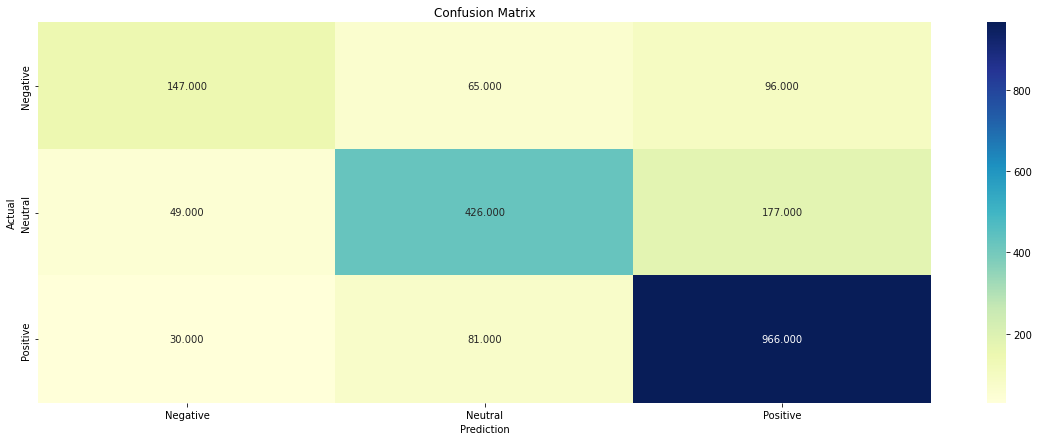

In [270]:
# Confusion Matrix:

C = confusion_matrix(Y_test, Y_pred) 
labels = ["Negative","Neutral","Positive"] # since we have 9 classes

# Confusion Matrix
plt.figure(figsize=(20,7))
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [271]:
("F1 score on test :",f1_score(Y_test,Y_pred,average = 'weighted'))

('F1 score on test :', 0.7471017293943243)

In [272]:
("F1 score on test :",f1_score(Y_test,Y_pred,average = 'micro'))

('F1 score on test :', 0.7555228276877761)